# **9-4. ResNet**
-------
## **다시 정리하는 ResNet**
연구와 발전으로, 신경망의 층 수가 많을 수록 이미지에서 더 좋은 특징을 추출할 수 있다는 것을 발견.(다양한 추상화 수준의 특징 학습 가능)    
👉 더 많이 쌓자(50층, 101층, 152층)

신경망 층 수 증가로 발생하는 과적합 문제, 기울기 소실 문제를 해결하기 위해 다양한 해결책 사용.    
- 과적합 문제: 드롭아웃, L2 규제화, 배치 정규화
- 기울기 소실: **⭐스킵 연결(잔차 블록)**    

과적합 문제 해결을 위한 강한 배치 정규화 적용으로, 깊은 신경망의 복잡도를 VGGNet19보다 낮출 수 있음.
<br><br>

### **Skip connection(Shortcut connection)**


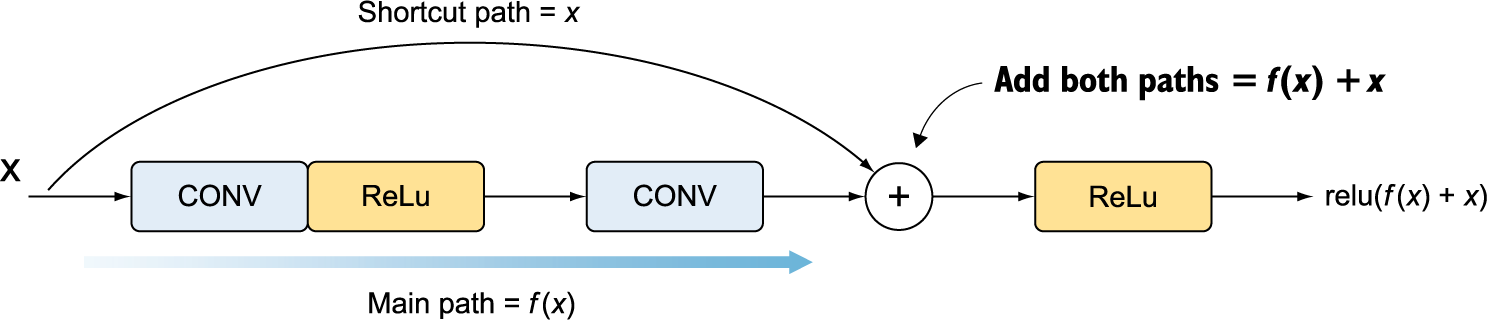

**스킵 연결**이란, **뒷 층의 기울기 값(정보)를 앞 층에 직접 전달하는 별도의 경로를 추가하는 방법**.   

뒷 층의 입력을 그대로 다음 층에 출력에 더하는 형태로 정보를 전달하면서, 학습 방향을 따라 계산된 출력값을 f(x)로 묶을 수 있고, layer는 깊지만, 어떻게 보면 깊지 않은 느낌(?)으로 학습할 수 있음.   

**기존 층이 기울기를 직접 전파**하기 때문에, 다음 층이 학습할 내용을 추가로 넣는게 아니라, 이미 학습한 내용을 그대로 사용하는 게 됨. 따라서 다음 층은 빠르게 수렴할 수 있고, 이는 더 나은 성능으로 모델을 이끌수 있음.    

스킵 연결로 앞 층에 전달되는 기울기는 **f(x)+x**로, 학습 시 앞의 항등함수를 학습하는 형태가 됨. 때문에 새로운 층이 추가되도 이전 층이 그대로 사용되므로, 층이 많이 쌓여도 **앞 층 보다 성능이 하락되지 않음**.    

**합성곱층에 스킵 연결을 추가한 구조**를 **잔차 블록(Residual Block)**이라고 함.
<br><br>

## **ResNet 구조**
여러개의 잔차 블록이 늘어선 형태로, 이미지넷 분류 문제 Top-5 오차율 4.49%를 달성.(앙상블 모델은 3.57%)

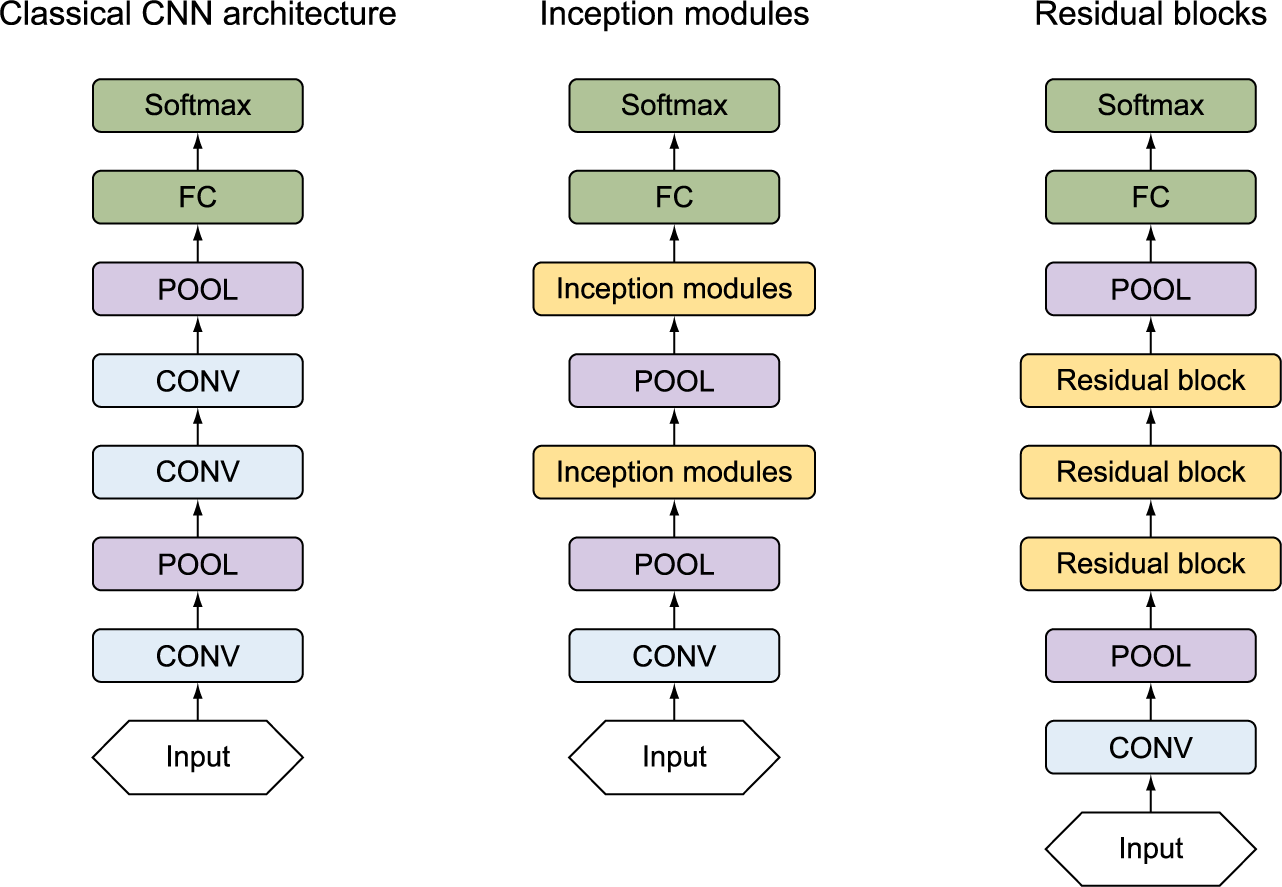

- 특징 추출기(합성곱층 + 풀링층, 그 뒤에 잔차 블록 한개 이상)
- 분류기(전결합층 + 소프트맥스)
<br><br>

### **ResNet 잔차 블록**


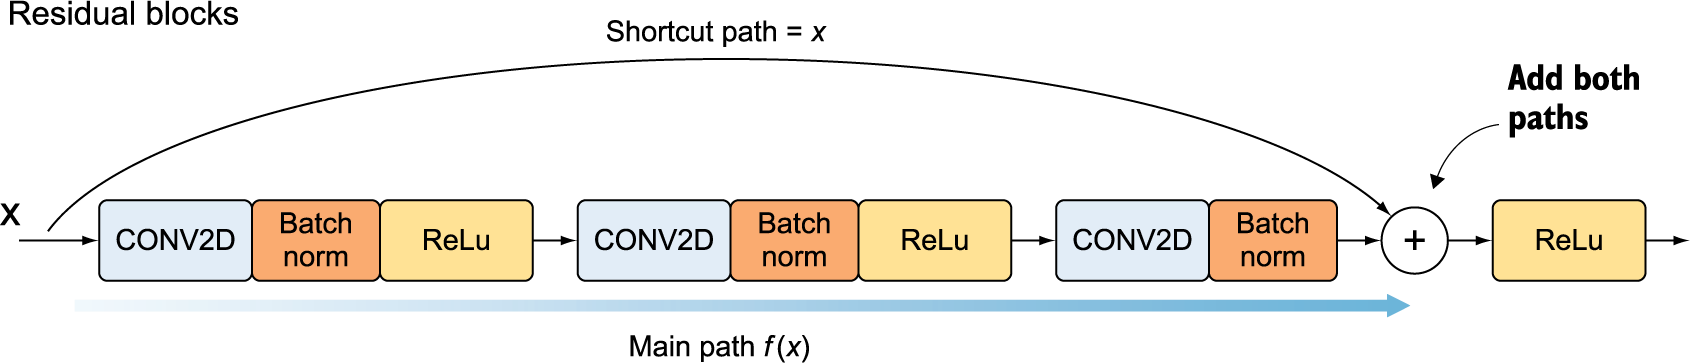

활성화 함수: ReLU
- 주 경로
    - 일련의 합성곱 연산 및 활성화 함수. 3개의 합성곱 층으로 구성, 각 합성곱층마다 배치 정규화 적용.
    - [CONV → BN → ReLU] x 3
- 지름길 경로
    - 입력을 주 경로에서 합성곱층의 활성화 함수 바로 앞에 전달

지름길 경로 값 + 주 경로의 값이 ReLU함수로 통과됨.   

차원 축소가 적용되면 이를 **병목 잔차 블록(Bottleneck residual block)**이라 하며, 여러 층에 걸쳐 입출력의 차원 제어 가능함.   
<br>


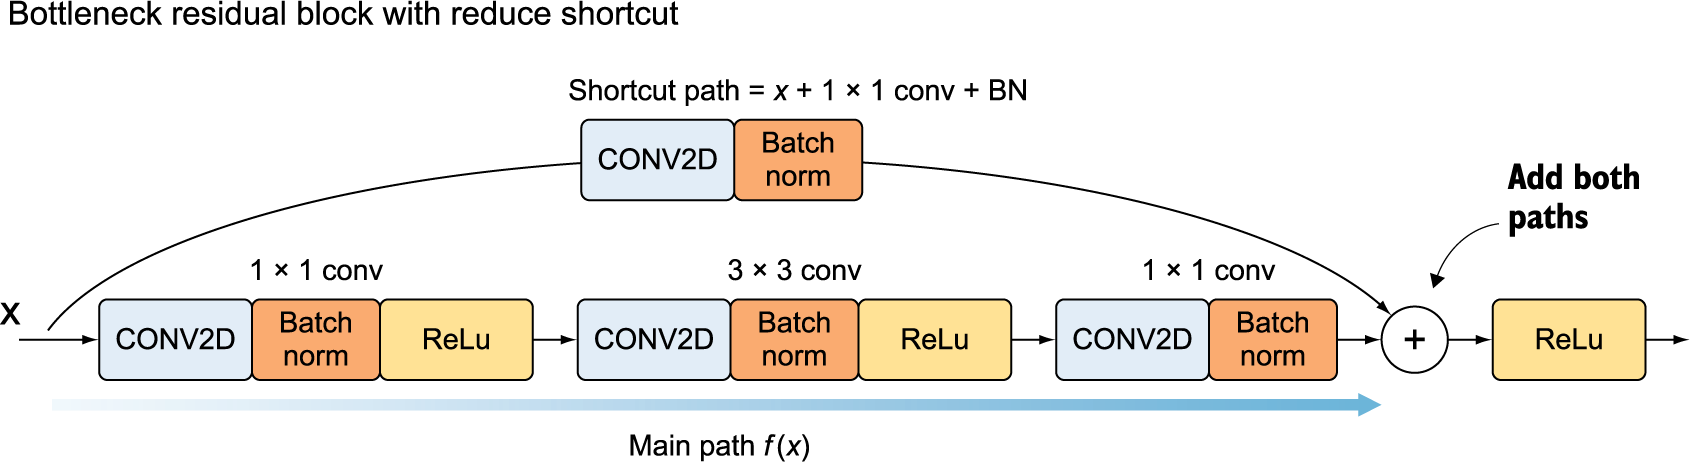

주 경로와 지름길 경로로 전달되는 정보의 차원이 동일해야 행렬 덧셉이 가능하기 때문에, 각 경로에서 나오는 결과값에 각각 차원 축소를 적용시킴.(= 축소 지름길 경로, Reduce shortcut)

- 주 경로
    - 풀링층이 없고, 대신 1 X 1 합성곱층으로 다운샘플링 적용.
잔차 블록 처음에 1 X 1 합성곱을 배치하고, 출력에 3 X 3, 1 X 1 합성곱을 하나씩 배치해서 두 번에 걸쳐 차원을 축소함.(각 합성곱층에 배치 정규화를 적용)

- 지름길 경로
    - 병목층 적용(1 X 1 합성곱층 + 배치정규화)
<br><br>

### **Bottle neck Residual Block**


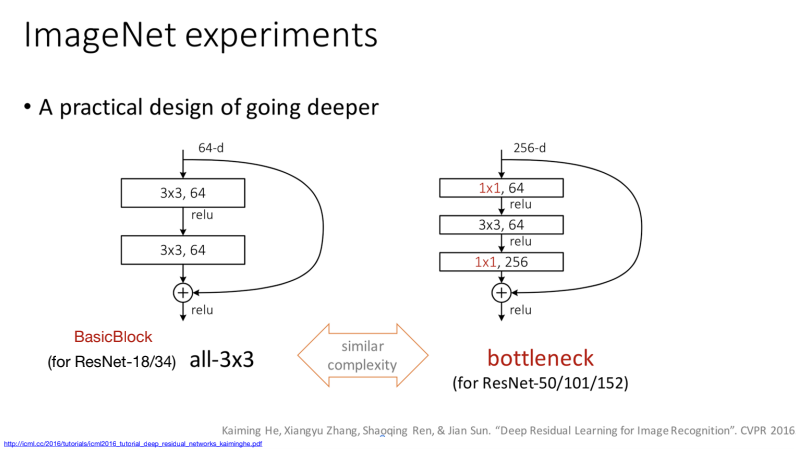

네트워크의 깊이를 증가시키면서, parameter 수와 연산량을 줄이는 방법.   
(1 x 1), (3 x 3), (1 x 1) Convolution Layer를 연속으로 쌓아 네트워크를 구성.   
네트워크의 길이도 증가시키면서, 계산 비용도 감소함.   

>- 1 x 1층
    - 입력의 차원을 줄이고
>- 3 x 3층
    - 데이터의 특징을 추출한 다음,
>- 1 x 1층
    - 데이터의 차원을 복원한다

<br>

### **1 x 1 합성곱층의 의미**
- 차원 축소, 확장
    - 공간 구조를 변화시키지 않으면서, 채널 수를 조정할 수 있음.
- 비선형성 도입
- 계산 비용 감소
<br><br>

## **ResNet의 하이퍼 파라미터**
- 모멘텀 0.9
- 학습률 초기값 0.1, 검증 오차 감소 없으면 학습률 1/10 감소
- 가중치 감쇠율 0.0001
- L2 규제화 함께 사용


In [1]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    '''3x3 convolution with padding'''
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)#kernel size 3이어서 padding 1

def conv1x1(in_planes, out_planes, stride=1):
    '''1x1 convolution'''
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)#kernel size가 1이어서 padding 0

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
        # Residual Block
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x # 전 층에서의 출력값

        # 3x3 stride = 2
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        #3x3 stride = 1
        out = self.conv2(out)
        out = self.bn2(out)

        #downsample은 out과 identity의 shape가 다를 떼를 대비한 것
        #예를 들어, x가 3x64x64일 때 3x3 합성곱층 stride가 1이 아니라 2일 때 out은 3x32x32가 됨.
        #다르면 둘이 못 더하니까 identify도 낮춰줌.
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)

        return out

In [3]:
class Bottleneck(nn.Module):
    # 3번째 convolution layer지날 때 채널이 4배로 증가해서
    expansion = 4
        # Residual Block
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) #conv1x1(64, 64)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride) #conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) #conv1x1(64, 256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        # 1x1 stride = 1
        out = self.conv1(x)
        out = self.bn1(x)
        out = self.relu(out)

        # 3x3 stride = stride
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 1x1 stride = 1
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            indentity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class ResNet(nn.Module):
    # model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs) #resnet 50
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()

        self.inplanes = 64
        # inputs 3 x 224 x 224
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # outputs = self.conv1(inputs)
        # outputs.shape = 64 x 112 x 112
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # inputs 64 x 112 x 112
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # outputs = [64 x 56 x 56]
        self.layer1 = self._make_layer(block, 64, layers[0]) #3
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) #4
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) #6
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) #3

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # 각각의 residual branch의 마지막 BN은 0으로 초기화 한다.
        # 따라서 residual branch는 0부터 시작하고, 각 residual block이 입력을 그대로 전달하여 identity 함수처럼 동작한다
        # identity: 단순히 입력을 그대로 출력으로 전달하는 함수
        # 초기에 네트워크가 학습을 시작할 때, 이러한 skip connection이 실제로 그 어떤 영향도 주지 않을 수 있습니다.
        #이는 skip connection의 출력이 아직 학습되지 않았기 때문입니다.
        #따라서 이러한 문제를 해결하기 위해, 마지막 BN (Batch Normalization) 층의 가중치를 제로로 초기화하여
        #네트워크의 일부가 학습을 시작할 때 "identity"처럼 동작하도록 만듭니다.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0) #여기서의 weight는 scale
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    #self.inplanes = 64
    #self.inplanes = 256
    #self.layer1 = self._make_layer(Bottleneck, 64, 3)
    #self.layer2 = self._make_layer(Bottleneck, 128, 4)
    def _make_layer(self, block, planes, blocks, stride=1):

        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion: #64 != 64 * 4(256)
            # 채널 수를 맞추기 위해
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), #conv1x1(64, 256, 1)
                                                                          #conv1x1(256, 512, 2)
                nn.BatchNorm2d(planes * block.expansion), #batchnorm2d(256)
                                                          #batchnorm2d(512)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        #layers.append(block(64, 64, 1, downsample))
        #layers.append(block(256, 128, 1, downsample))

        self.inplanes = planes * block.expansion #self.inplanes = 64 * 4 = 256

        for _ in range(1, blocks):
            #for _ in range(1, 3)
            #for _ in range(1, 4)
            layers.append(block(self.inplanes, planes)) # * 2
                                                        # * 3
        #self.layer1=[
            #Bottleneck(64, 64, 1, downsample)
            #Bottleneck(256, 64)
            #Bottleneck(256, 64)
        #]

        #self.layer2=[
            #Bottleneck(256, 128, 2, downsample)
            #Bottleneck(512, 128)
            #Bottleneck(512, 128)
            #Bottleneck(512, 128)
        #]
        return nn.Sequential(*layers)


    def forward(self, x):
        #conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #pool
        x = self.maxpool(x)

        # bottleneck
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # pool(FC Layer 대체, 1x1으로 평균을 내서 묶어버린다)
        x = self.avgpool(x)
        #FC
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs) #=> 2*(2+2+2+2) +1(conv1) +1(fc)  = 16 +2 =resnet 18
    return model

In [5]:
def resnet50(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs) #=> 3*(3+4+6+3) +(conv1) +1(fc) = 48 +2 = 50
    return model

In [ ]:
def resnet152(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs) # 3*(3+8+36+3) +2 = 150+2 = resnet152
    return model

In [8]:
res = resnet50()

In [9]:
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torchvision.models.resnet as resnet

In [12]:
res = resnet.resnet50()

res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 